In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import itertools

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run


In [8]:
data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L2_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights

In [28]:
runs = 3
m1 = [1e-1]
m2 = [0.9, 0.7, 0.5]
HPs = itertools.product(m1, m2)

experiments_csv = path_exps / Path("LBFGS_grid_search.csv")
# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    HPs_new = []
    for m1,m2 in HPs:
        if ((df['m1'] == m1) & (df['m2'] == m2)).any():
            continue
        else:
            HPs_new.append((m1,m2))
    HPs = HPs_new

for m1, m2 in HPs:
    print(f'Testing m1: {m1}, m2: {m2}', end='')
    solver = LBFGS(eps=1e-4, max_feval=5e4, M=10,m1=m1,m2=m2)
    results = multi_run(solver, f, n=runs)

    log_columns = ["m1", "m2", "f_evals_m", "f_evals_std", "n_failures", "runs"]
    log_data = [m1, m2, results[2], results[3], results[6], runs]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

Testing m1: 0.1, m2: 0.9	 Finished
Testing m1: 0.1, m2: 0.7	 Finished
Testing m1: 0.1, m2: 0.5	 Finished


In [29]:
df = pd.read_csv(experiments_csv)
df.sort_values(by=['f_evals_m'])

,m1,m2,f_evals_m,f_evals_std,n_failures,runs
7,0.0100,0.7,6463.666667,2622.694840,0,3
4,0.0010,0.7,6506.666667,2842.746129,0,3
6,0.0100,0.9,6885.333333,2995.110942,0,3
1,0.0001,0.7,7353.666667,2820.631647,0,3
10,0.1000,0.7,7906.333333,3263.104895,0,3
3,0.0010,0.9,8014.000000,2616.572695,0,3
11,0.1000,0.5,8188.000000,3931.072458,0,3
9,0.1000,0.9,8876.000000,3143.515972,0,3
0,0.0001,0.9,10229.666667,4724.823548,0,3
2,0.0001,0.5,13680.000000,0.000000,2,3


Text(33.0, 0.5, 'm1')

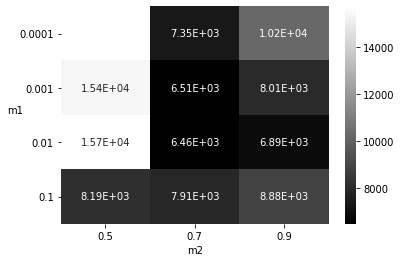

In [30]:
import seaborn as sns
df = pd.read_csv(experiments_csv)
# set failures as nulls
df.loc[df['n_failures'] > 0,'f_evals_m'] = np.nan
df = df.sort_values(by=['m1','m2'])
m1_vals = df['m1'].unique()
m2_vals = df['m2'].unique()
array = df['f_evals_m'].to_numpy()
matrix = array.reshape((len(m1_vals), len(m2_vals)))

ax = sns.heatmap(matrix,cmap='gray', annot=True,fmt='1.2E',
xticklabels=m2_vals, yticklabels=m1_vals)
plt.yticks(rotation=0)
ax.set_xlabel('m2')
ax.set_ylabel('m1',rotation=0)

In [9]:
runs = 3
M_list = [5, 10, 20, 50, 100, 200]
m1 = 0.01
m2 = 0.7

experiments_csv = path_exps / Path("LBFGS_memory_search.csv")
# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    M_list_new = []
    for M in M_list:
        if (df['M'] == M).any():
            continue
        else:
            M_list_new.append(M)
    M_list = M_list_new

for M in M_list:
    print(f'Testing M: {M}, m1: {m1}, m2: {m2}', end='')
    solver = LBFGS(eps=1e-4, max_feval=5e4, M=M,m1=m1,m2=m2)
    results = multi_run(solver, f, n=runs)

    log_columns = ["M", "m1", "m2", "f_evals_m", "f_evals_std", "n_failures", "runs", "seconds_m", "seconds_std"]
    log_data = [M, m1, m2, results[2], results[3], results[6], runs, results[4], results[5]]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

Testing M: 5, m1: 0.01, m2: 0.7	 Finished
Testing M: 10, m1: 0.01, m2: 0.7	 Finished
Testing M: 20, m1: 0.01, m2: 0.7	 Finished
Testing M: 50, m1: 0.01, m2: 0.7	 Finished
Testing M: 100, m1: 0.01, m2: 0.7	 Finished
Testing M: 200, m1: 0.01, m2: 0.7	 Finished


In [10]:
df = pd.read_csv(experiments_csv)
# set failures as nulls
df.loc[df['n_failures'] > 0,'f_evals_m'] = np.nan
df.sort_values(by='f_evals_m')

,M,m1,m2,f_evals_m,f_evals_std,n_failures,runs,seconds_m,seconds_std
4,100,0.01,0.7,2667.000000,1023.144499,0,3,16.432585,1.621665
5,200,0.01,0.7,3178.000000,1278.568992,0,3,21.721200,1.030480
2,20,0.01,0.7,6037.666667,2145.393567,0,3,34.279113,5.603720
3,50,0.01,0.7,6722.333333,2318.530617,0,3,39.139852,6.750963
1,10,0.01,0.7,7011.666667,2943.484594,0,3,40.623052,3.339229
0,5,0.01,0.7,8048.333333,3176.262094,0,3,46.259685,2.363848


<ErrorbarContainer object of 3 artists>

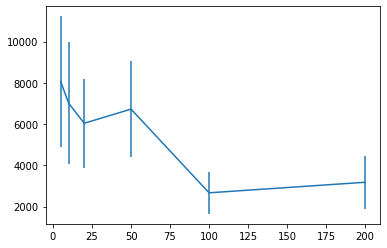

In [11]:
plt.errorbar(x=df['M'],y=df['f_evals_m'],yerr=df['f_evals_std'])


<ErrorbarContainer object of 3 artists>

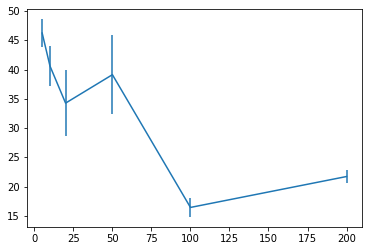

In [12]:

plt.errorbar(x=df['M'],y=df['seconds_m'],yerr=df['seconds_std'])